In [1]:
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, Compose, ToTensor, ToPILImage
import matplotlib.pyplot as plt
import wandb
import datasets
import pandas as pd
from tqdm import tqdm

In [2]:
def transforms(img_size:int):
    return Compose([RandomResizedCrop(size=img_size, scale=[0.4, 1], ratio=[0.75, 1.33], interpolation=2), 
                    RandomHorizontalFlip(p=0.5), 
                    ToTensor()])

def load_ds(imgs, patch_size, transforms):
    img = transforms(imgs)
    imgp = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size).permute((0, 3, 4, 1, 2)).flatten(3).permute((3, 0, 1, 2))
    return imgp

In [25]:
data_imgs = datasets.load_dataset("spacevision-upb/MOD_LSTD_E_downscaled")
idx_df = pd.read_csv('../local_ds.csv')['hf_idx']
imgs = data_imgs['train']['image']
imgs = [imgs[i] for i in idx_df]
# imgs = [load_ds(img,patch_size = 32, transforms=transforms(224)) for img in imgs]

Resolving data files:   0%|          | 0/1123 [00:00<?, ?it/s]

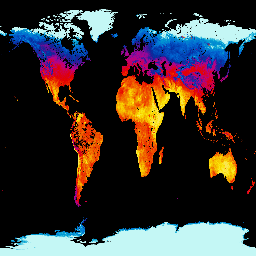

In [26]:
imgs[0]

In [23]:
import matplotlib.pyplot as plt
from transformers import ViTFeatureExtractor
import requests
from PIL import Image

feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-base")
imagenet_mean = np.array(feature_extractor.image_mean)
imagenet_std = np.array(feature_extractor.image_std)
def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def visualize(pixel_values, model):
    # forward pass
    outputs = model(pixel_values)
    y = model.unpatchify(outputs.logits)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    
    # visualize the mask
    mask = outputs.mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.config.patch_size**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', pixel_values)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

/home/sebnae/miniforge3/envs/deep/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


/tmp/ipykernel_468276/1947475691.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())


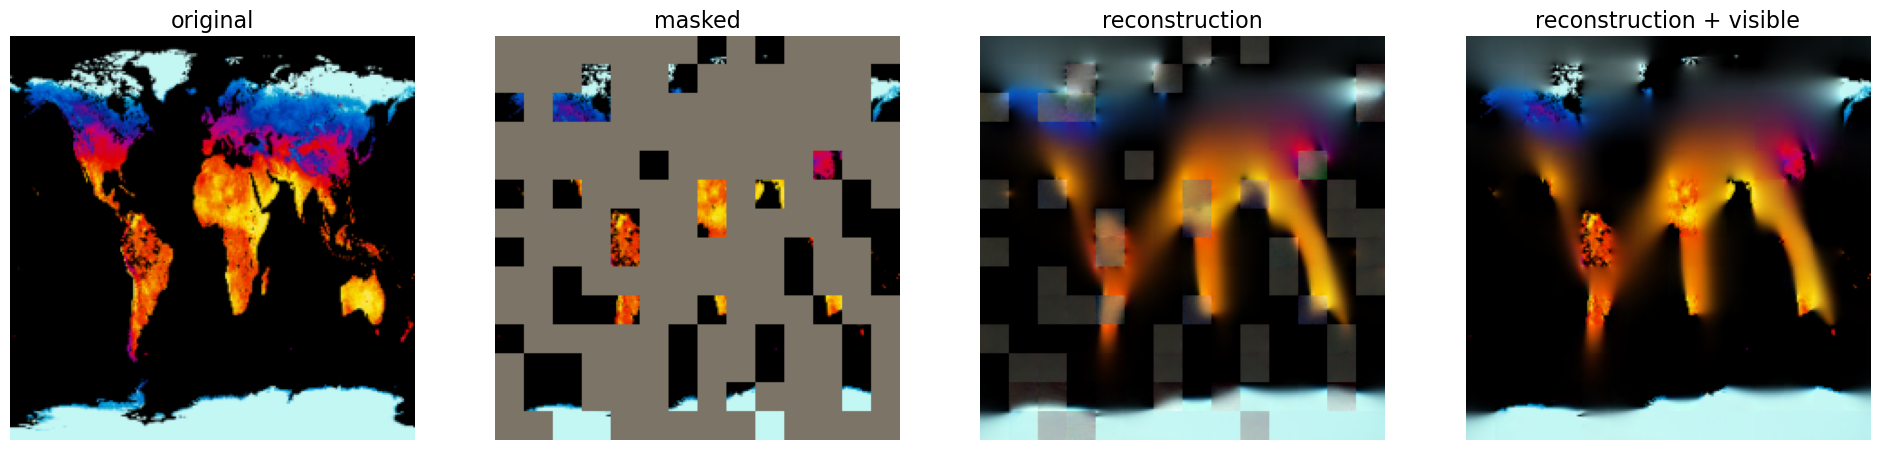

In [27]:
from transformers import ViTMAEForPreTraining

torch.manual_seed(2)
image = imgs[0]
pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
visualize(pixel_values, model)